In [4]:
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np

### Supplemental Figure: rate of adaptation across SARS-CoV-2 genome

In [5]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [6]:
def get_adaptive_muts_over_time(virus, method, gene, window):
    """
    For the specified gene, read in the number of adaptive mutations at over time, and the rate of adaptation
    """
    
    all_timepoints = []
    
    
    if method=='kistler':
        json_name = f'adaptation_results/results_sars2/{virus}_{gene}_{window}_3_adaptation.json'
    elif method=='bhatt':
        json_name = f'bhatt_results/bhatt_results_sars2/{virus}_{gene}_{window}_bhatt_analysis.json'
        

    if path.exists(json_name):
        with open(json_name) as handle:
            json_dict = json.load(handle)
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'])

    else:
        print(f'{gene} analysis has not been run')

    for t in range(len(window_midpoint)):
        all_timepoints.append({'virus': 'sars2', 
                               'gene': gene, 
                               'timepoint': window_midpoint[t],
                               'method': method,
                               'adaptive_subs_per_codon': adaptive_substitutions_per_codon[t], 
                               'rate_of_adaptation': rate_of_adaptation})

    return all_timepoints

In [7]:
def plot_sars2_supplement(virus, genes_to_plot, method, window, filename=None):
    """
    Plot rate of adaptation in each gene, 
    and the plot of adaptive mutations across each time window for a handful of genes
    """
    
    configs = readin_virus_config(virus)
    all_genes = configs['genes']
    
    #greens= structural proteins
    #darker green= surface, lighter= non-surface
    #reds = nonstructural proteins
    #oranges/yellows = accessory proteins
    legend_colors = {'Non-structural': '#9F2A44', 
                     'Structural,\nsurface': '#208288', 
                     'Structural,\nnon-surface': '#76C7BE', 
                     'Accessory':'#F5AD52'}
    legend_edgecolors = {'Non-structural': '#621a2a', 
                     'Structural,\nsurface': '#165b5f', 
                     'Structural,\nnon-surface': '#46ab97', 
                     'Accessory':'#eb520d'}
    
    color_map = {"ORF1a": '#9F2A44', "ORF1b": '#9F2A44', 
                 "S1": '#208288', "S2": '#208288', 
                 "ORF3a": '#F5AD52', "E": '#76C7BE', "M":'#76C7BE', "ORF6": '#F5AD52', 
                 "ORF7a": '#F5AD52', "ORF7b": '#F5AD52', "ORF8": '#F5AD52', "N": '#76C7BE', "ORF9b": '#F5AD52'}
    edgecolor_map = {"ORF1a": '#621a2a', "ORF1b": '#621a2a', 
                     "S1": '#165b5f', "S2": '#165b5f', 
                     "ORF3a": '#eb520d', "E":'#46ab97',  "M": '#46ab97', "ORF6": '#eb520d', 
                     "ORF7a": '#eb520d', "ORF7b": '#eb520d', "ORF8": '#eb520d', "N": '#46ab97', "ORF9b":'#eb520d'}
    
    #get the adaptative mutation results
    data_to_plot = []
    rates_of_adaptation = {}
    
    for gene in all_genes:
        all_timepoints = get_adaptive_muts_over_time(virus, method, gene, window)
        data_to_plot+=all_timepoints
        rate = all_timepoints[0]['rate_of_adaptation']*1000
        rates_of_adaptation[gene] = rate
    
    df = pd.DataFrame(data_to_plot)
    
    
    
    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['legend.fontsize'] = 6
    
    plt.rcParams['figure.dpi']= 300
    
    #initiate plot
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(3, 2)

    ax1 = fig.add_subplot(gs[:, 0])
    #plot rate of adaptation for each gene
    for g in all_genes:
        ax1.plot(rates_of_adaptation[g], g, 'o', ms=8, color=color_map[g], markeredgecolor=edgecolor_map[g])
    
    ax1.set_xlabel(r'Adaptive Muts per Codon per Year $(x 10^{-3})$')
    ax1.set_ylabel('')
    #add figure panel label
    ax1.text(-0.07, 1.05, 'A', horizontalalignment='center', 
                   verticalalignment='center', weight='bold', fontsize=16, transform=ax1.transAxes)
    
    #add a legend
    handles = []
    leg_text = []
    for k,v in legend_colors.items():
        handles.append(Line2D([], [], color='white', marker='o', 
                              markerfacecolor=v, markeredgecolor=legend_edgecolors[k], markersize=8))
        leg_text.append(k)
        
    leg = ax1.legend(handles, leg_text,
                      bbox_to_anchor=(0.58, 1.1), frameon=True, labelspacing = 1.0, borderpad=1)
    
    
    for i in range(3):
        #get data for just the specified genes
        g = genes_to_plot[i]
        data_subset = df[df['gene']==g]

        if i==0:
            ax = fig.add_subplot(gs[i, 1])
        else:
            ax = fig.add_subplot(gs[i, 1], sharey=ax)
            
        
        #plot adapative mutations at each timepoint
        X = data_subset['timepoint']
        Y = data_subset['adaptive_subs_per_codon']
        #get linear fit
        coef = np.polyfit(X, Y, 1)
        poly1d_fn = np.poly1d(coef)
        
        ax.plot(X, Y, 'o', ms=5, color=color_map[g],
                           markeredgewidth=0.5, markeredgecolor=edgecolor_map[g])
        ax.plot(X, poly1d_fn(X), '-', linewidth=2, color=edgecolor_map[g])
        
        #label the gene being plotted
        ax.text(0.05, 1.0, g, horizontalalignment='left', color='#808080',
               verticalalignment='center', weight='bold', fontsize=10, transform=ax.transAxes)
        
        ax.set_yticks([0.00, 0.02, 0.04])
        ax.set_xticks([2020, 2021, 2022, 2023])
        
        #add figure panel label
        panel_labels = {0:'B', 1:'C', 2:'D'}
        if i==0:
            ax.text(-0.2, 1.2, panel_labels[i], horizontalalignment='center', 
                           verticalalignment='center', weight='bold', fontsize=16, transform=ax.transAxes)
        #label y-axis on middle plot
        if i==1:
            ax.set_ylabel('Adaptive Muts per Codon')
            ax.yaxis.set_label_coords(-0.12, 0.7)
        #label x-axis on bottom plot
        if i==2:
            ax.set_xlabel('Date')
        
    # remove box around plot
    sns.despine(left=False, bottom=False)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')

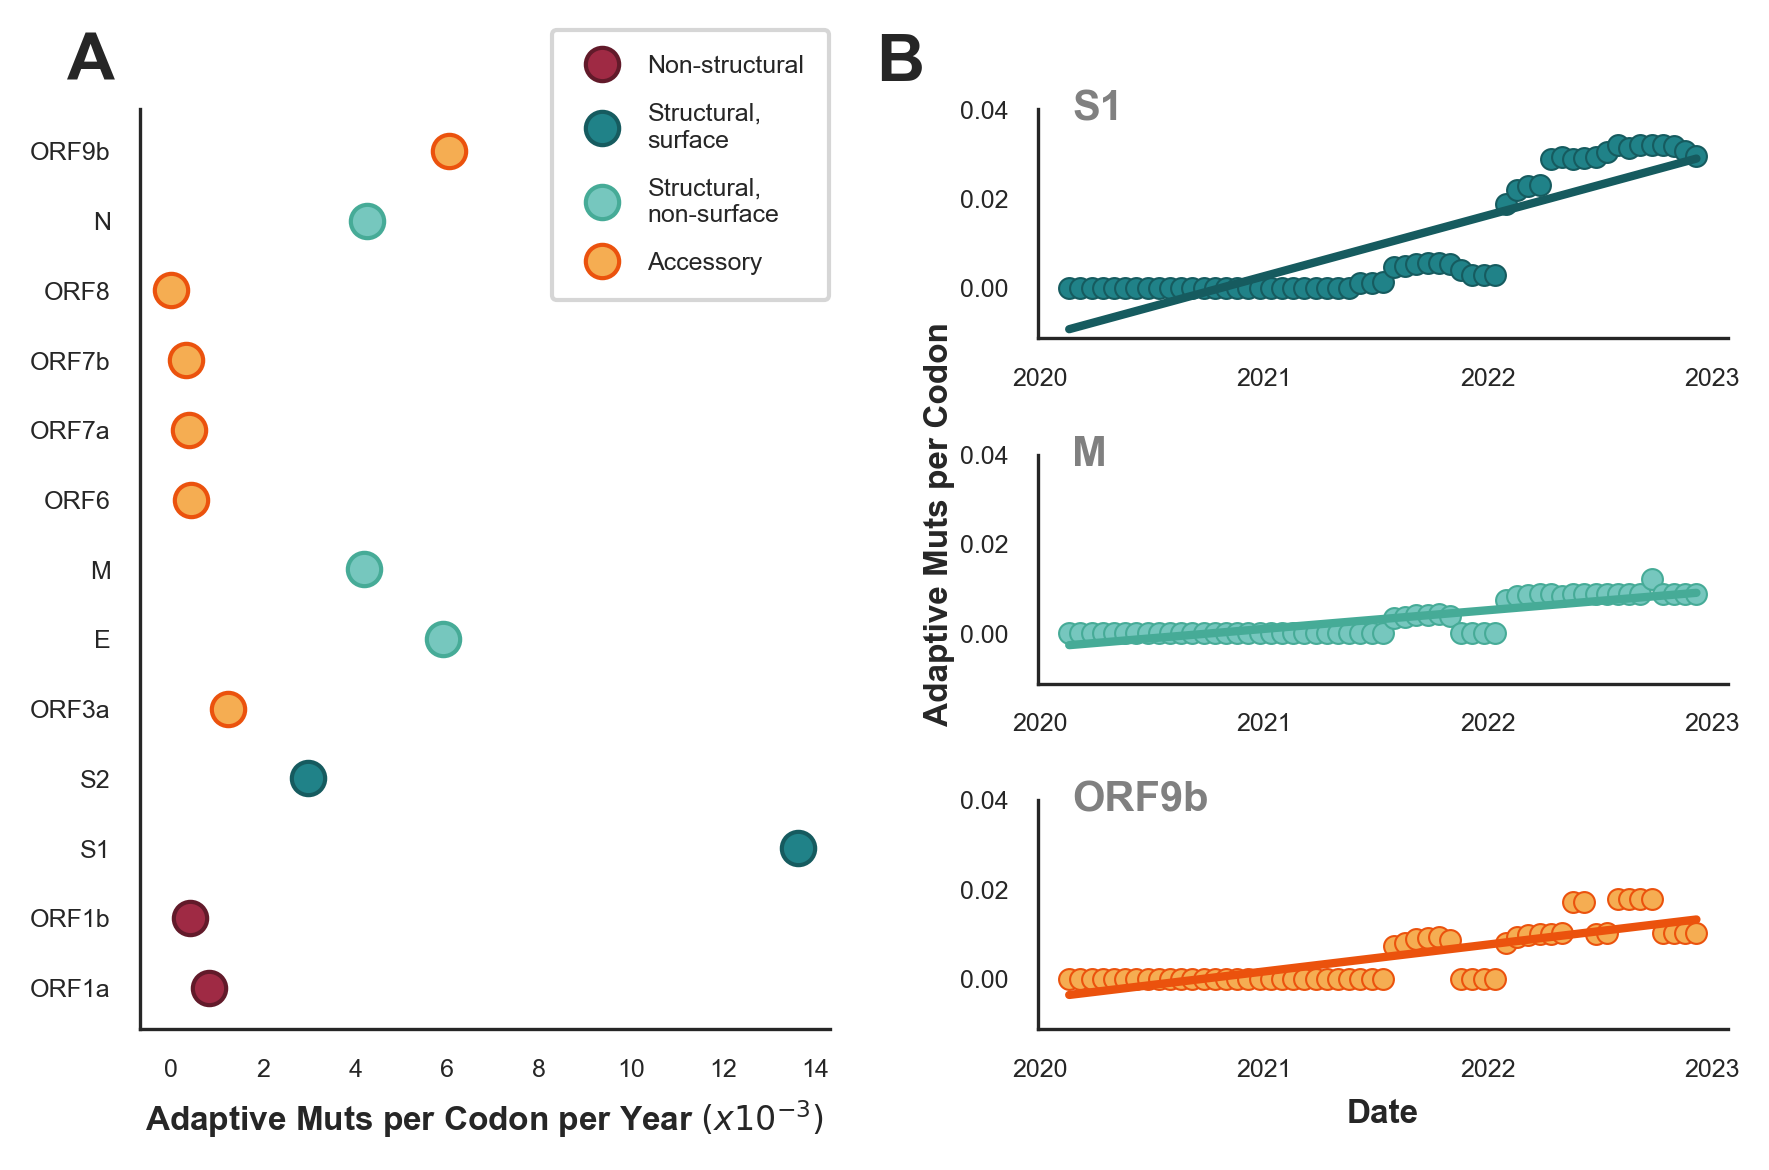

In [251]:
plot_sars2_supplement(['S1', 'M', 'ORF9b'], 'kistler', 0.3, filename = 'manuscript_figures/Supplement_sars2.png')

In [87]:
def plot_adaptative_muts_over_time(genes, method, window):
    
    data_to_plot = []
    
    for gene in genes:
        all_timepoints = get_adaptive_muts_over_time(method, gene, window)
        data_to_plot+=all_timepoints
    
    df = pd.DataFrame(data_to_plot)
    
    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.rcParams['legend.fontsize'] = 8
    
    plt.rcParams['figure.dpi']= 300
    
    color = '#5100f3'
    edgecolor = '#23006a'
    
    #initiate plotting axes
    num_rows_to_plot = math.ceil(len(genes)/2)
    fig, axs = plt.subplots(num_rows_to_plot, 2, figsize=(8, 6), sharey=True, sharex=True)
    
    for i in range(len(genes)):
        g = genes[i]
        data_subset = df[df['gene']==g]
        
        X = data_subset['timepoint']
        Y = data_subset['adaptive_subs_per_codon']
        #get linear fit
        coef = np.polyfit(X, Y, 1)
        poly1d_fn = np.poly1d(coef)
        
        row = int(i/2)
        if i%2 == 0:
            col = 0
        else:
            col = 1
        #plot adaptive mut estimates at each time point
        axs[row, col].plot(X, Y, 'o', ms=6, color=color,
                           markeredgewidth=0.5, markeredgecolor=edgecolor)
        #plot linear regression
        axs[row, col].plot(X, poly1d_fn(X), '-', linewidth=2, color='#a9acf9')
        
        axs[row, col].text(0.1, 0.9, 
                       g, fontsize=10, transform=axs[row, col].transAxes)
        
        #label x-axis on bottom plots only
        if row==(num_rows_to_plot-1):
            axs[row, col].set_xlabel("Date")
        #label y-axis on one left plot only
        if col==0 and row== (num_rows_to_plot/2):
            axs[row, col].set_ylabel("Adaptive Mutations per Codon")
        
    fig.tight_layout()
    
    # remove box around plot
    sns.despine(left=False, bottom=False)

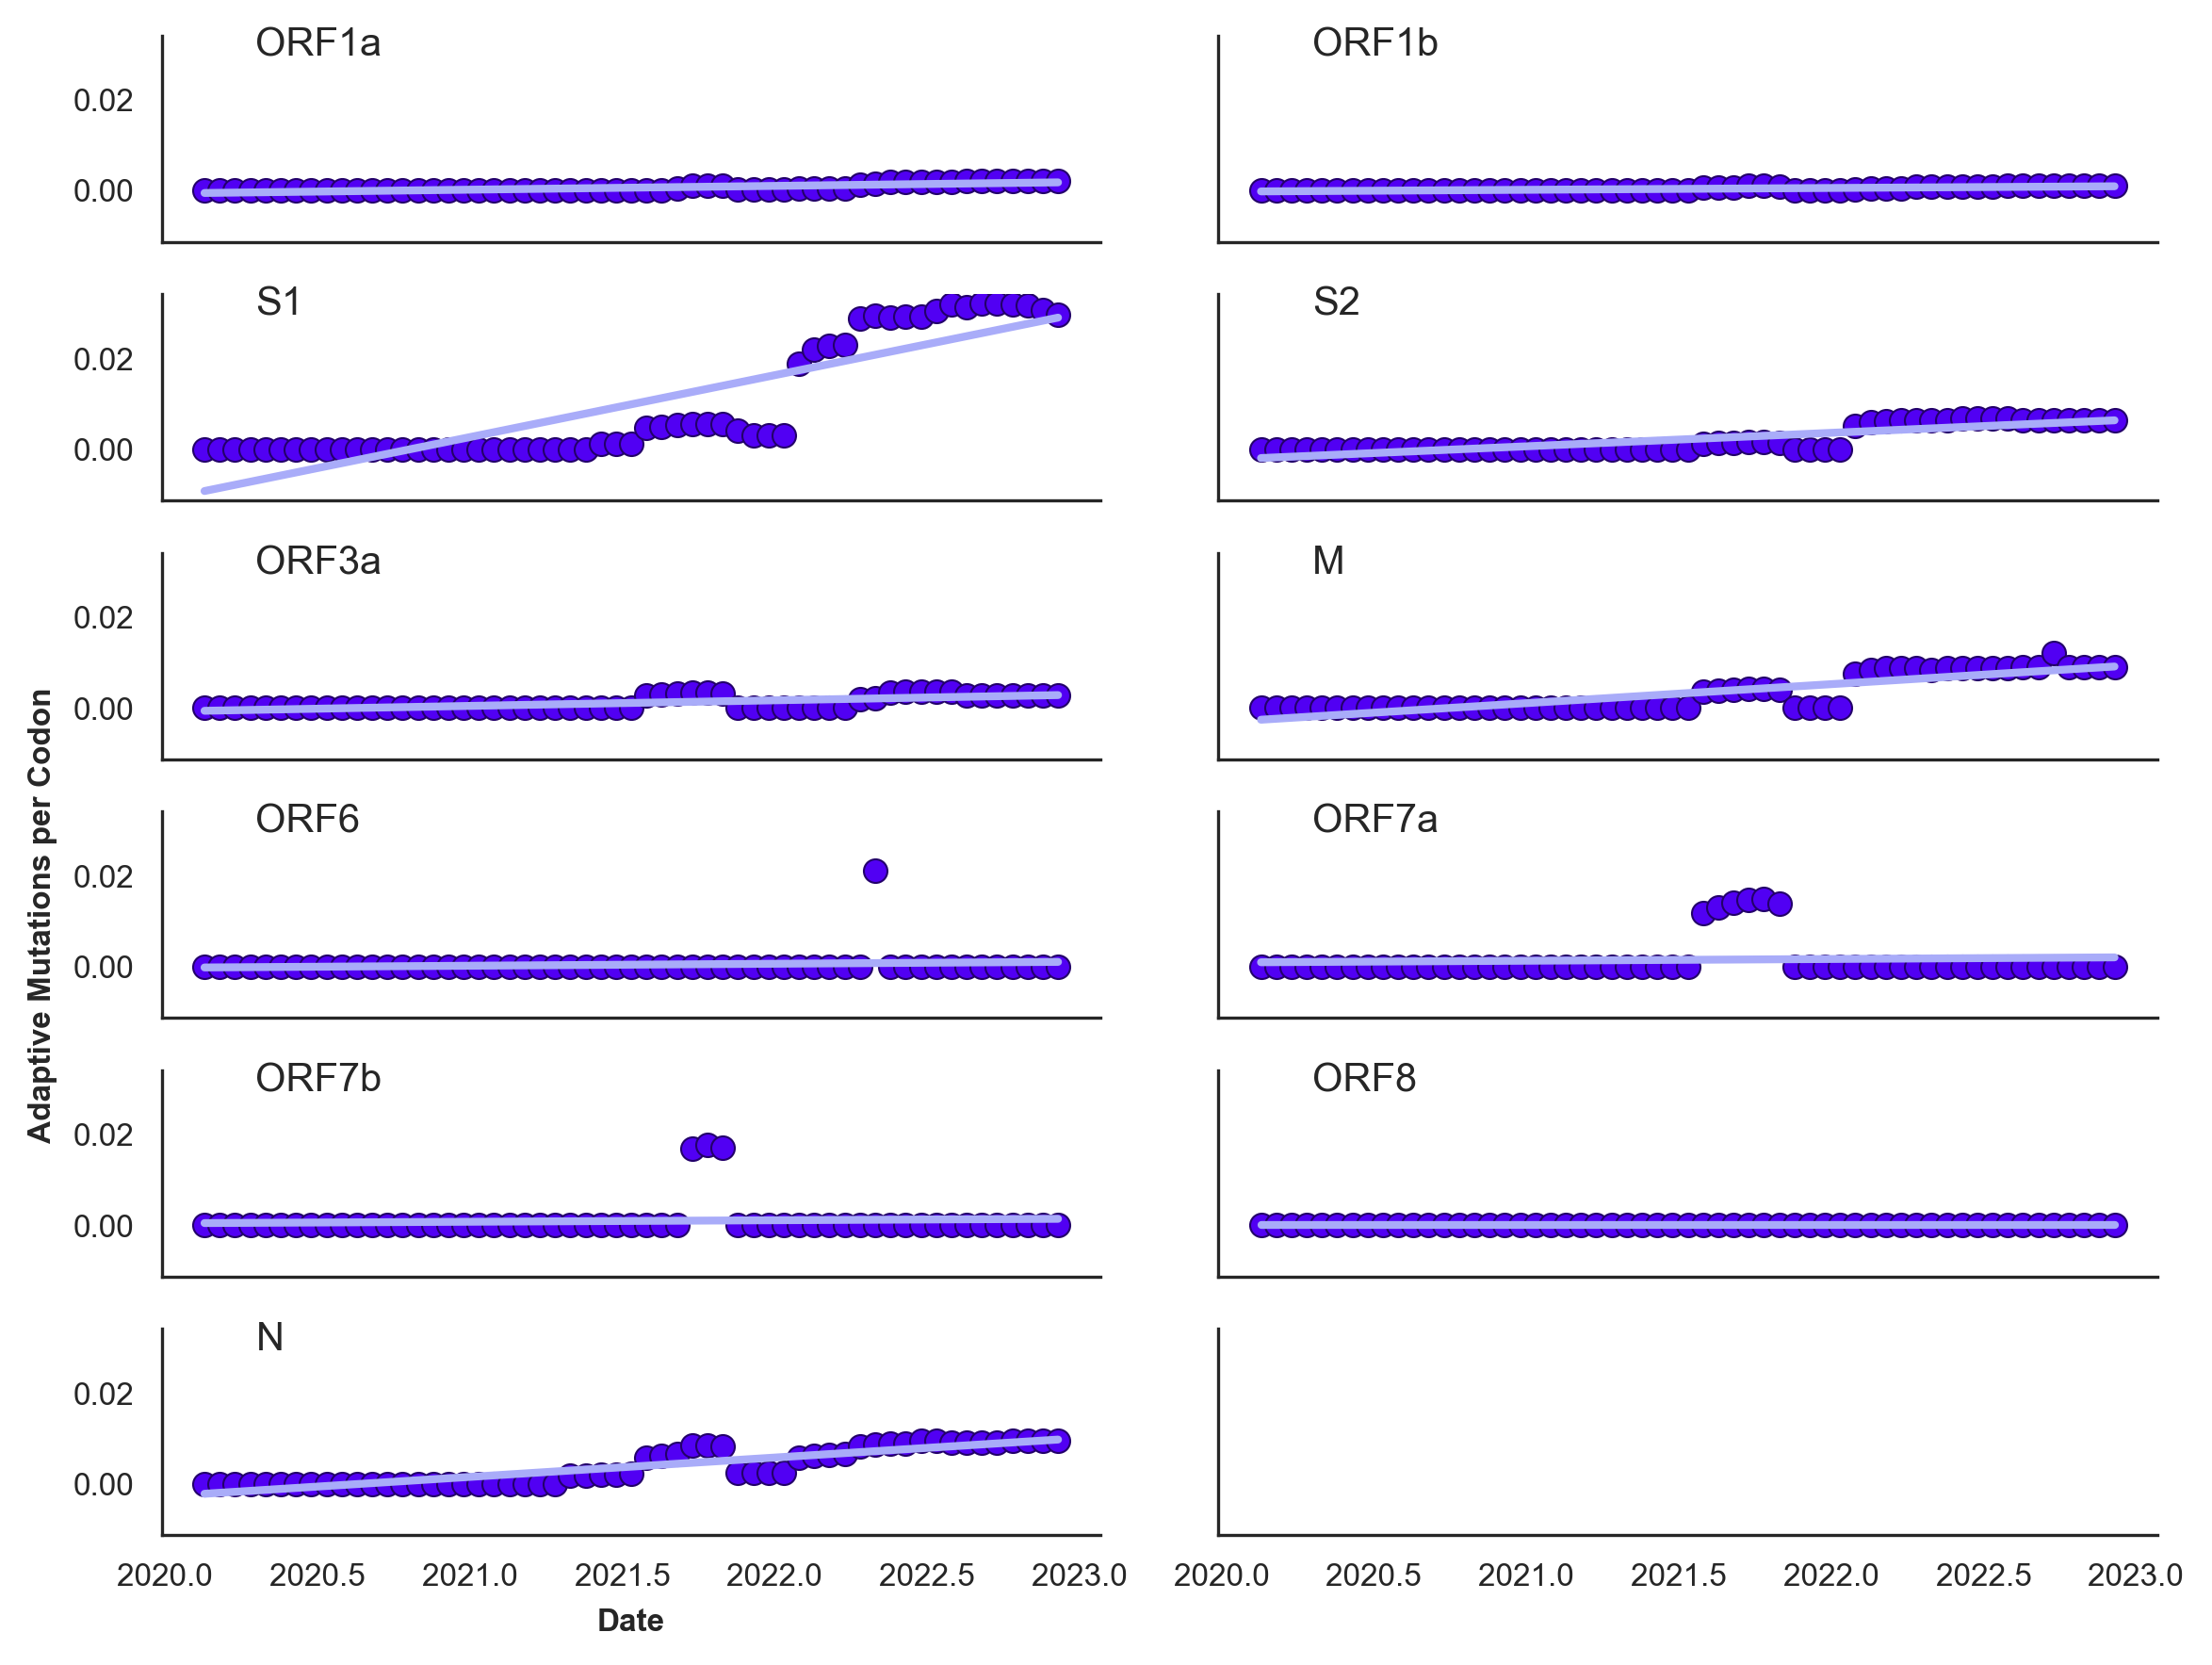

In [88]:
plot_adaptative_muts_over_time(['ORF1a', 'ORF1b', 'S1', 'S2', 
                                'ORF3a', 'M', 'ORF6', 'ORF7a', 
                                'ORF7b', 'ORF8', 'N'], 
                               'kistler', 0.3)

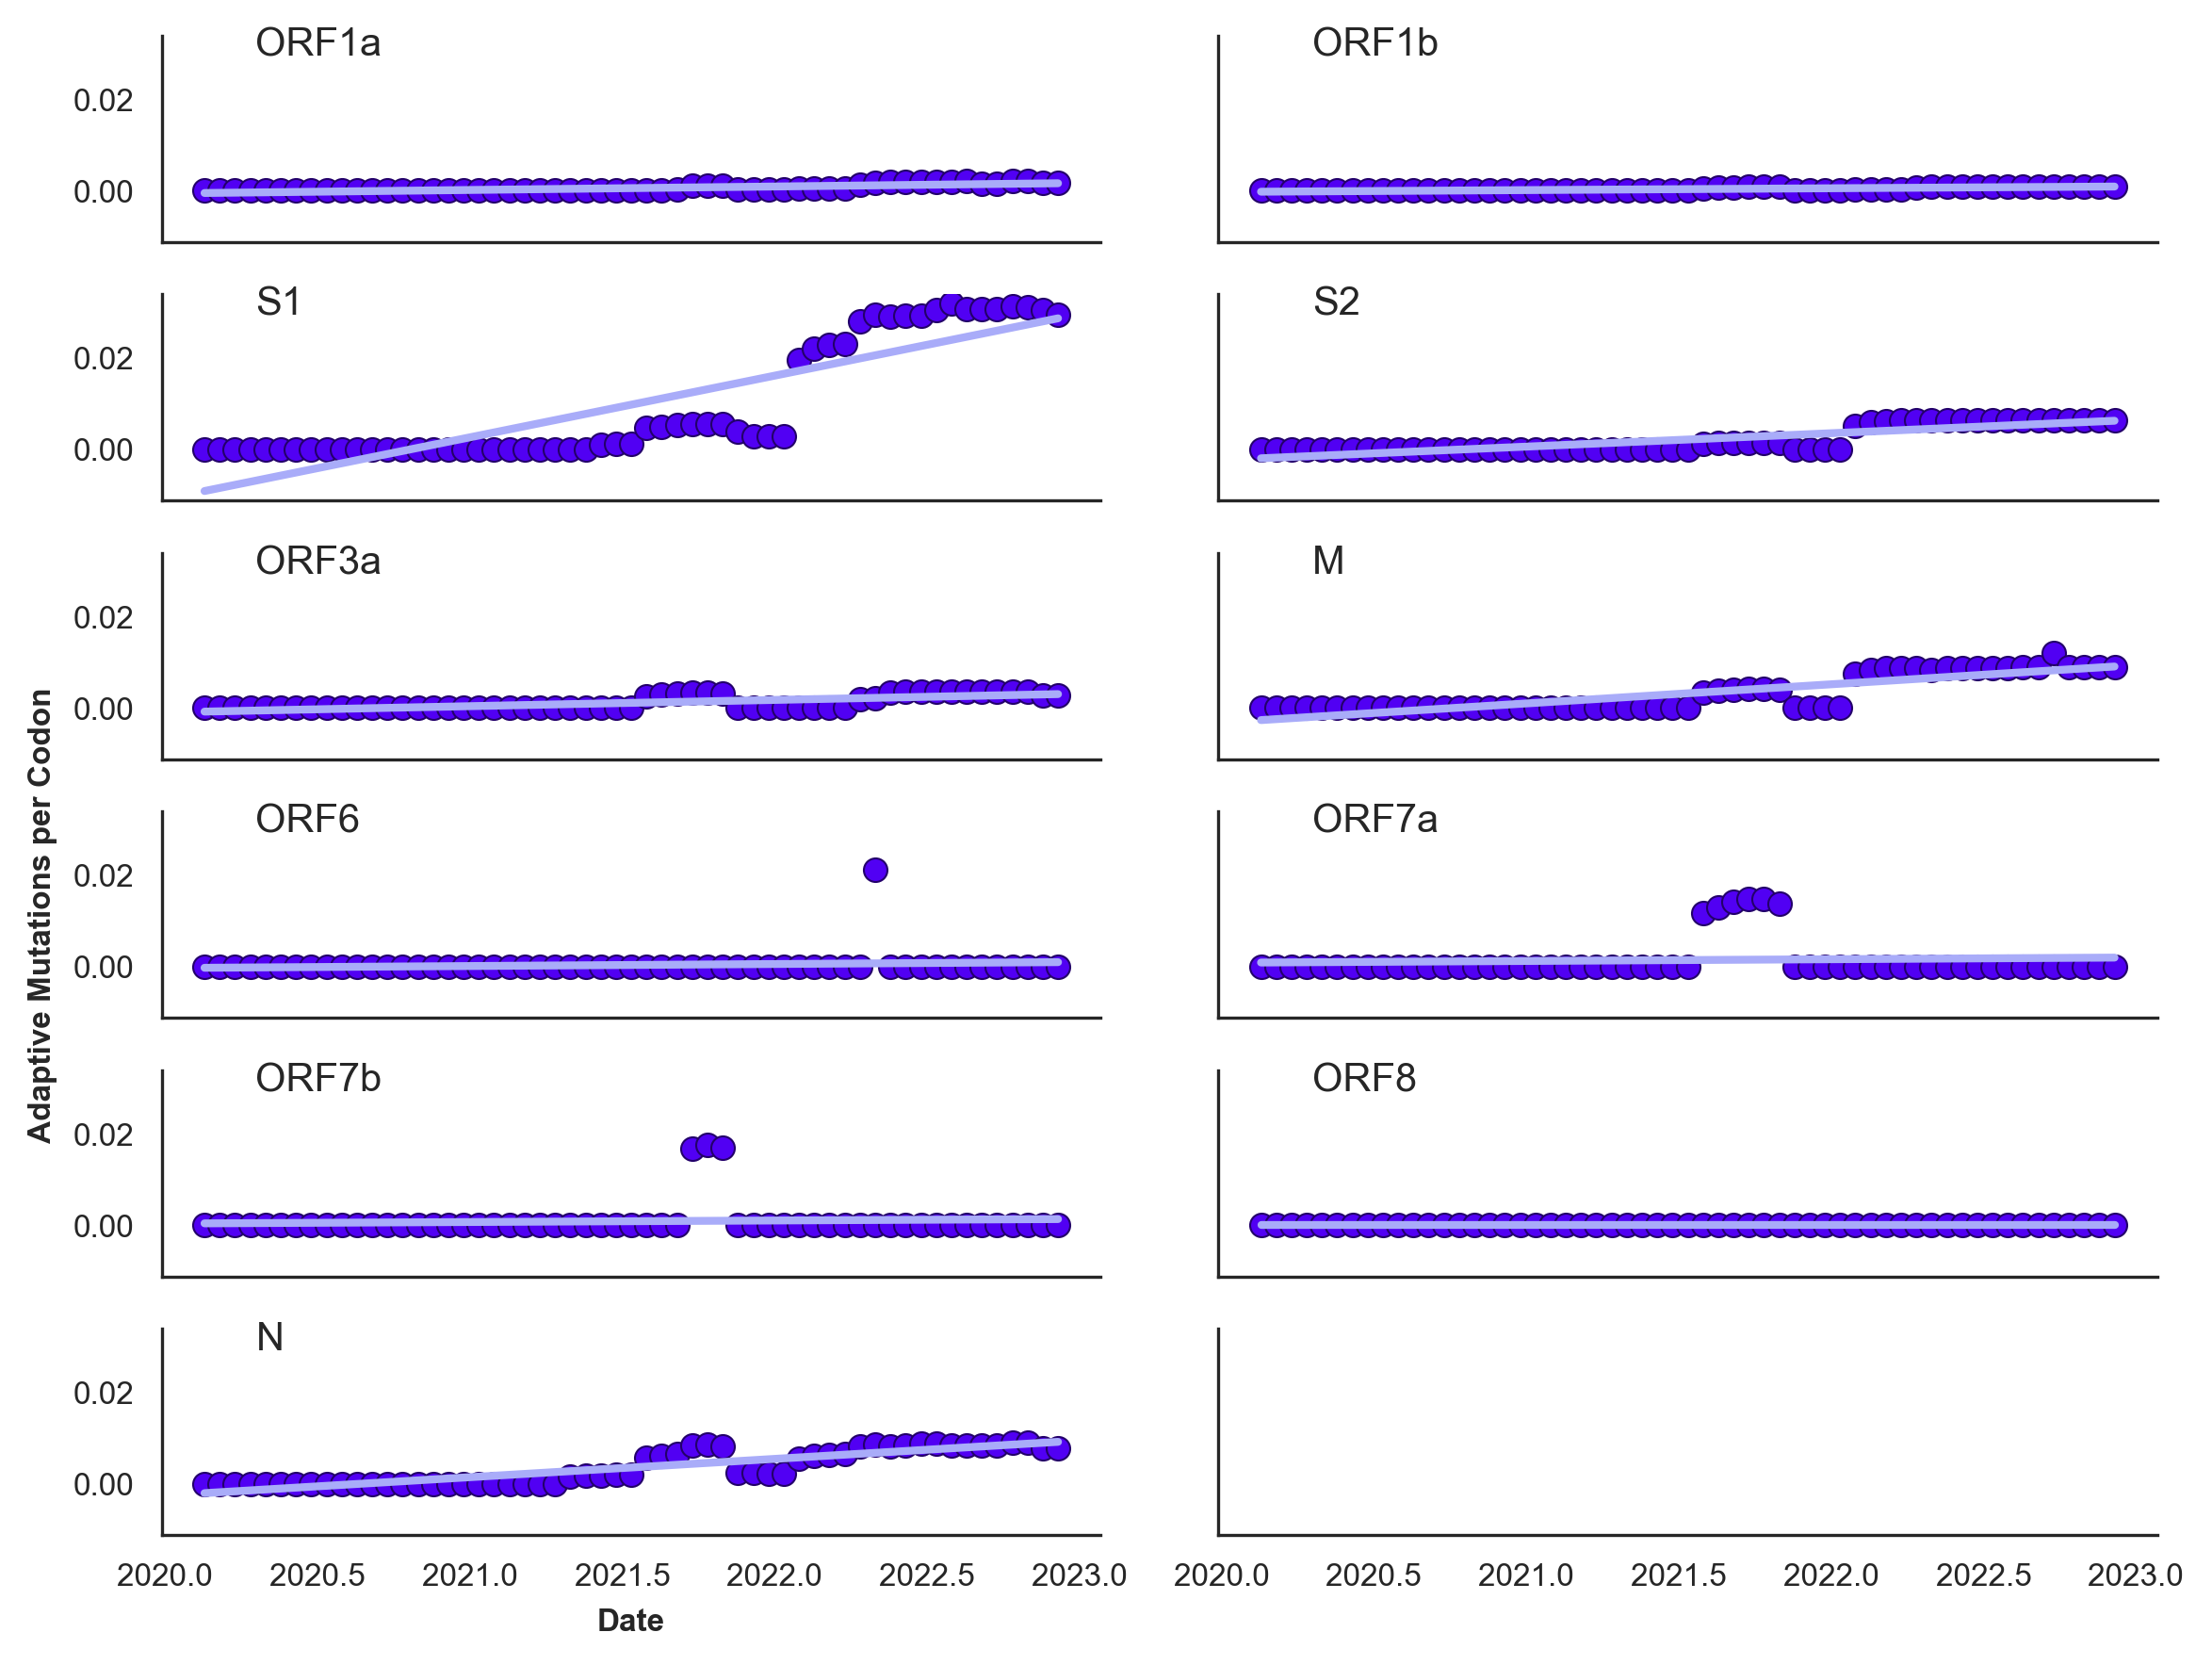

In [89]:
plot_adaptative_muts_over_time(['ORF1a', 'ORF1b', 'S1', 'S2', 
                                'ORF3a', 'M', 'ORF6', 'ORF7a', 
                                'ORF7b', 'ORF8', 'N'], 
                               'bhatt', 0.3)